In [7]:
import pandas as pd                                     # for data loading, manipulation, and analysis
import numpy as np                                      # for numerical operations and handling arrays                 
from sklearn.impute import SimpleImputer                # for handling missing data
from sklearn.preprocessing import StandardScaler        # for feature scaling
from sklearn.model_selection import train_test_split    # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression       # for linear regression model
from sklearn.metrics import mean_absolute_error         # for evaluating the model
from sklearn.metrics import mean_squared_error          # for evaluating the model
import matplotlib.pyplot as plt                         # for plotting
import time                                             # for tracking the time


In [8]:
# Start the timer for preprocessing
preprocessing_start_time = time.time()

# Load the Ames dataset
file_path = '../data/AmesData.csv'
ames_df = pd.read_csv(file_path)

# Specifically replace blanks in 'MasVnrArea' with 0
ames_df.replace({'MasVnrArea': 'nan'}, 0, inplace=True)

# Identify columns with missing values
missing_values = ames_df.isnull().sum()
print("\nColumns with missing values and their counts before preprocessing:")
print(missing_values[missing_values > 0])

# Handle missing values for numerical columns
num_imputer = SimpleImputer(strategy='median')
num_cols_with_missing = ames_df.select_dtypes(include=[np.number]).columns[ames_df.select_dtypes(include=[np.number]).isnull().any()].tolist()
ames_df[num_cols_with_missing] = num_imputer.fit_transform(ames_df[num_cols_with_missing])

# Handle missing values for categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_cols_with_missing = ames_df.select_dtypes(exclude=[np.number]).columns[ames_df.select_dtypes(exclude=[np.number]).isnull().any()].tolist()
ames_df[cat_cols_with_missing] = cat_imputer.fit_transform(ames_df[cat_cols_with_missing])

# Ensure no missing values remain
print("\nColumns with missing values after imputation and their counts:")
print(ames_df.isnull().sum()[ames_df.isnull().sum() > 0])

# Convert boolean columns to integer
bool_cols = ames_df.select_dtypes(include=[bool]).columns.tolist()
ames_df[bool_cols] = ames_df[bool_cols].astype(int)

# Check the number of rows and columns in the dataset before outlier removal
num_rows, num_columns = ames_df.shape
print(f"\nThe dataset contains {num_rows} rows and {num_columns} columns before outlier removal.")

# Remove outliers based on 'GrLivArea'
initial_row_count = ames_df.shape[0]
ames_df = ames_df.drop(ames_df[ames_df['GrLivArea'] > 4000].index)
final_row_count = ames_df.shape[0]
print(f"Number of rows removed based on 'GrLivArea' > 4000: {initial_row_count - final_row_count}")

# Check the number of rows and columns in the dataset after outlier removal
num_rows, num_columns = ames_df.shape
print(f"\nThe dataset contains {num_rows} rows and {num_columns} columns after outlier removal.")

# Encoding Categorical Variables
ames_df = pd.get_dummies(ames_df, drop_first=True)

# Check the number of rows and columns in the dataset after encoding
num_rows, num_columns = ames_df.shape
print(f"\nThe dataset contains {num_rows} rows and {num_columns} columns after encoding.")

# Standardize all numerical features except 'SalePrice'
scaler = StandardScaler()
num_features = ames_df.select_dtypes(include=[np.number]).columns
num_features = num_features.drop('SalePrice')
ames_df[num_features] = scaler.fit_transform(ames_df[num_features])

# Scale 'SalePrice' separately
saleprice_scaler = StandardScaler()
ames_df['SalePrice'] = saleprice_scaler.fit_transform(ames_df['SalePrice'].values.reshape(-1, 1))

# Check the number of rows and columns in the dataset after scaling
num_rows, num_columns = ames_df.shape
print(f"\nThe dataset contains {num_rows} rows and {num_columns} columns after scaling.")

# End the timer for preprocessing
preprocessing_end_time = time.time()
preprocessing_time = preprocessing_end_time - preprocessing_start_time
print(f"Preprocessing Time: {preprocessing_time:.2f} seconds")


Columns with missing values and their counts before preprocessing:
Alley           2593
MasVnrType      1629
MasVnrArea        21
BsmtQual          64
BsmtCond          64
BsmtExposure      67
BsmtFinType1      64
BsmtFinType2      65
Electrical         1
FireplaceQu     1277
PoolQC          2756
Fence           2227
MiscFeature     2671
dtype: int64

Columns with missing values after imputation and their counts:
Series([], dtype: int64)

The dataset contains 2769 rows and 80 columns before outlier removal.
Number of rows removed based on 'GrLivArea' > 4000: 5

The dataset contains 2764 rows and 80 columns after outlier removal.

The dataset contains 2764 rows and 256 columns after encoding.

The dataset contains 2764 rows and 256 columns after scaling.
Preprocessing Time: 0.17 seconds


Baseline Linear Regression Model Performance with TotalLivingArea:
Mean Absolute Error (MAE): $31735.20
Mean Squared Error (MSE): $1912756864.35
Training Time: 0.00 seconds


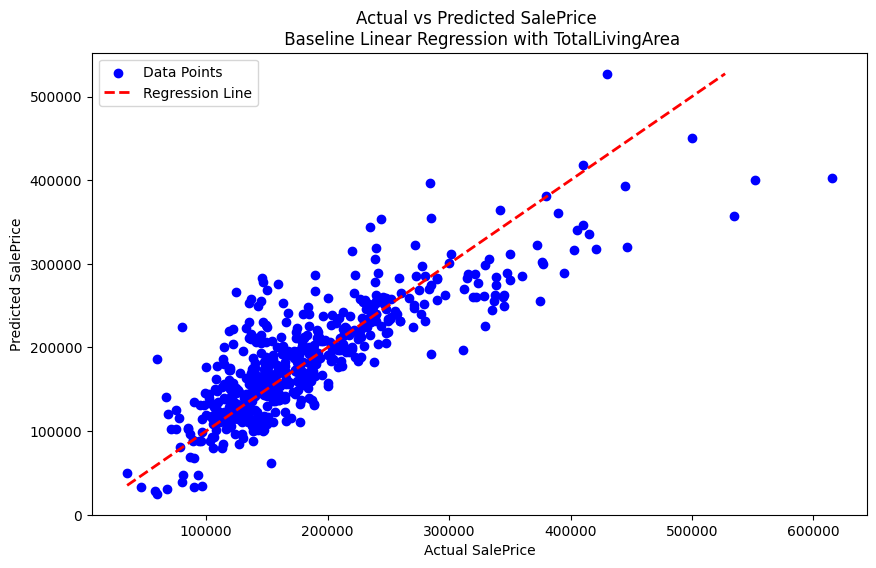

Regression Coefficients (Scaled): [0.50222409]
Intercept (Scaled): 0.007805554496110177
Regression Coefficients (Original Scale): TotalLivingArea: 23495.303012732336
Intercept (Original Scale): 184714.98335745296


In [10]:
# Create a new independent variable for total living area
ames_df['TotalLivingArea'] = ames_df['GrLivArea'] + ames_df['TotalBsmtSF']

# Prepare features and target variable
X = ames_df[['TotalLivingArea']]
y = ames_df['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Linear Regression model
lin_reg = LinearRegression()

# Start the timer for training
training_start_time = time.time()

# Train the model
lin_reg.fit(X_train, y_train)

# End the timer for training
training_end_time = time.time()
training_time = training_end_time - training_start_time

# Make predictions
y_pred = lin_reg.predict(X_test)

# Un-transform the predictions back to the original scale
y_pred_original = saleprice_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)

print("Baseline Linear Regression Model Performance with TotalLivingArea:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Training Time: {training_time:.2f} seconds")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_original.max()], [y_test_original.min(), y_pred_original.max()], 'r--', lw=2, label='Regression Line')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n Baseline Linear Regression with TotalLivingArea')
plt.legend()
plt.show()

# Print the regression coefficients and intercept for the scaled data
print(f"Regression Coefficients (Scaled): {lin_reg.coef_}")
print(f"Intercept (Scaled): {lin_reg.intercept_}")

# Adjust the coefficients and intercept to the original scale
total_living_area_mean = ames_df['TotalLivingArea'].mean()
total_living_area_std = ames_df['TotalLivingArea'].std()

saleprice_mean = saleprice_scaler.mean_[0]
saleprice_std = saleprice_scaler.scale_[0]

# Original scale coefficients
coef_total_living_area_original = lin_reg.coef_[0] * saleprice_std / total_living_area_std

# Original scale intercept
intercept_original = saleprice_mean - (coef_total_living_area_original * total_living_area_mean)

print(f"Regression Coefficients (Original Scale): TotalLivingArea: {coef_total_living_area_original}")
print(f"Intercept (Original Scale): {intercept_original}")

Baseline Linear Regression Model Performance with GrLivArea and TotalBsmtSF:
Mean Absolute Error (MAE): $31196.65
Mean Squared Error (MSE): $1877709123.93
Training Time: 0.00 seconds


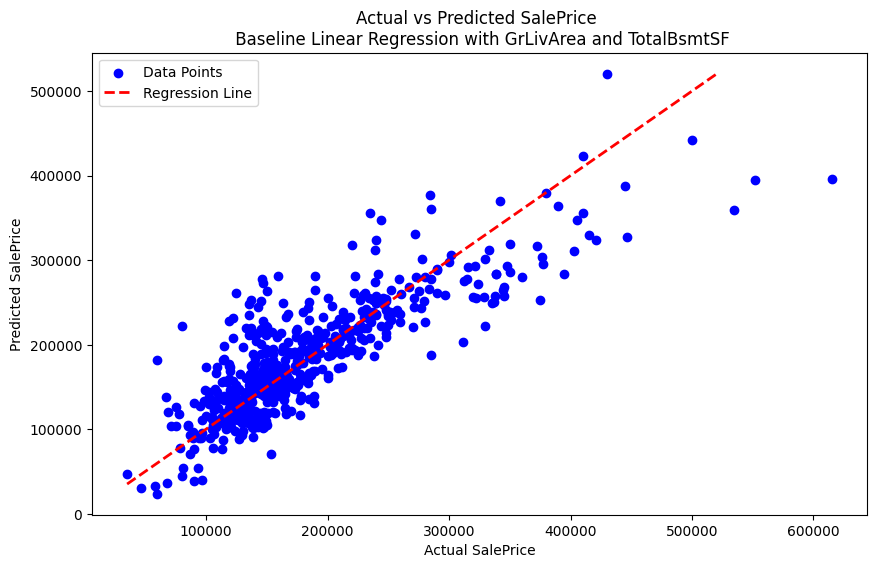

Regression Coefficients (Scaled): [0.55438746 0.44906689]
Intercept (Scaled): 0.006866642332271752
Regression Coefficients (Original Scale): [GrLivArea: 43335.41990724852, TotalBsmtSF: 35102.70957203978]
Intercept (Original Scale): 184714.98335745296


In [9]:
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare features and target variable
X = ames_df[['GrLivArea', 'TotalBsmtSF']]
y = ames_df['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Linear Regression model
lin_reg = LinearRegression()

# Train the model and time the training process
start_time = time.time()
lin_reg.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred = lin_reg.predict(X_test)

# Un-transform the predictions back to the original scale
y_pred_original = saleprice_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)

print("Baseline Linear Regression Model Performance with GrLivArea and TotalBsmtSF:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Training Time: {training_time:.2f} seconds")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_original.max()], [y_test_original.min(), y_pred_original.max()], 'r--', lw=2, label='Regression Line')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n Baseline Linear Regression with GrLivArea and TotalBsmtSF')
plt.legend()
plt.show()

# Print the regression coefficients and intercept for the scaled data
print(f"Regression Coefficients (Scaled): {lin_reg.coef_}")
print(f"Intercept (Scaled): {lin_reg.intercept_}")

# Adjust the coefficients and intercept to the original scale
grlivarea_mean = ames_df['GrLivArea'].mean()
grlivarea_std = ames_df['GrLivArea'].std()
totalbsmt_mean = ames_df['TotalBsmtSF'].mean()
totalbsmt_std = ames_df['TotalBsmtSF'].std()

saleprice_mean = saleprice_scaler.mean_[0]
saleprice_std = saleprice_scaler.scale_[0]

# Original scale coefficients
coef_grlivarea_original = lin_reg.coef_[0] * saleprice_std / grlivarea_std
coef_totalbsmt_original = lin_reg.coef_[1] * saleprice_std / totalbsmt_std

# Original scale intercept
intercept_original = saleprice_mean - (coef_grlivarea_original * grlivarea_mean + coef_totalbsmt_original * totalbsmt_mean)

print(f"Regression Coefficients (Original Scale): [GrLivArea: {coef_grlivarea_original}, TotalBsmtSF: {coef_totalbsmt_original}]")
print(f"Intercept (Original Scale): {intercept_original}")


The only difference between the two models is how the input features are selected and combined. The preprocessing steps, model training, prediction, and evaluation steps are the same for both models. The fact that the results are close indicates that the choice of feature combination does have a big impact, but both approaches can produce similar levels of accuracy when other aspects of preprocessing and model configuration are consistent.